# grabbing images from: https://esahubble.org/images/archive/category/galaxies/

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
from mike_code import LaguerreAmplitudes
from functionalities import *
import matplotlib.cm as cm
from skimage.transform import resize_local_mean
from mingus.midi import midi_file_out
#https://github.com/musalbas/musicalpackets/issues/17

In [3]:

######
#need to initialize fluidsynth with our soundfont - this just tells fluidsynth where our sounds live
fluidsynth.init("/Users/caf/Developer/sonify/env/GeneralUser GS 1.471/soundfont.sf2")
#coreaudio, file, portaudio seem to be only viable options
#possible drivers:  ‘alsa’, ‘oss’, ‘jack’, ‘portaudio’, ‘sndmgr’, ‘coreaudio’, ‘Direct Sound’, ‘dsound’, ‘pulseaudio’

#####################
#### setting instruments for positive, negative channels
#####################
fluidsynth.set_instrument(1,1) #put piano on channel 1 - positive notes will be piano
fluidsynth.set_instrument(2,49) #put string ensemble on channel 2 - negative notes will be strin

returning coscoefs, sincoefs
max, min, median of reconstruction: 293.8810635575645 1.4583489220879455 24.537836969450765
max, min, median of original image: 253.45608718766618 7.390005316321107 24.682801701222765
returning reconstruction, cosine coefficients, and sine coefficients


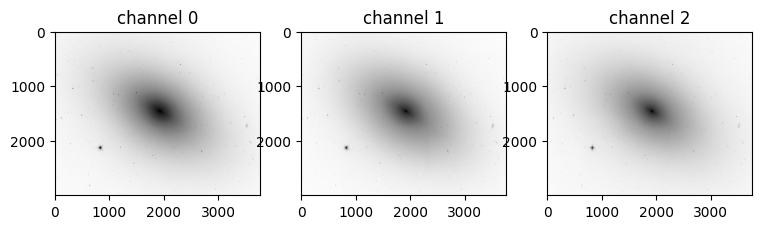

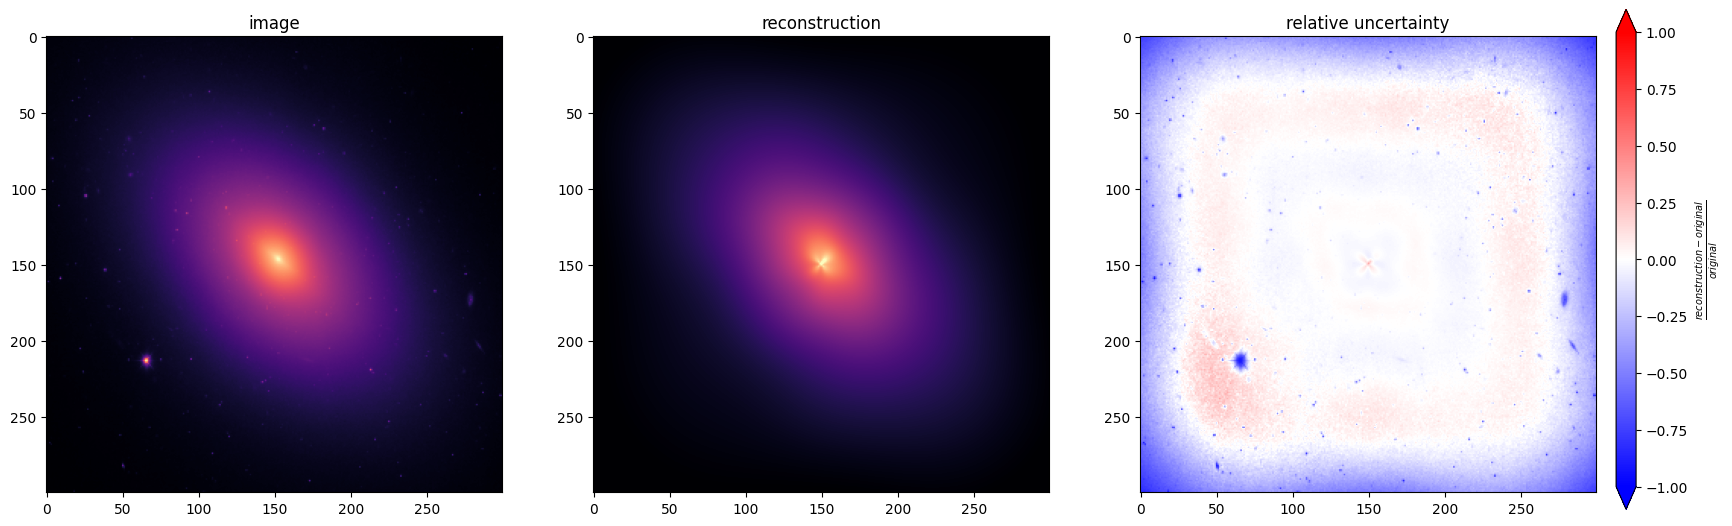

In [19]:
#image_path, rescale_factor, rscale, recon_lims, save_loc = None, savestr = None
recon, cos_cos, sin_cos = beef_it('high_qual_elliptical_ngc4621.tif', rescale_factor=.1, 
                                  rscale=500, recon_lims=3000)#, save_loc = './', savestr = 'ngc4621_recon')

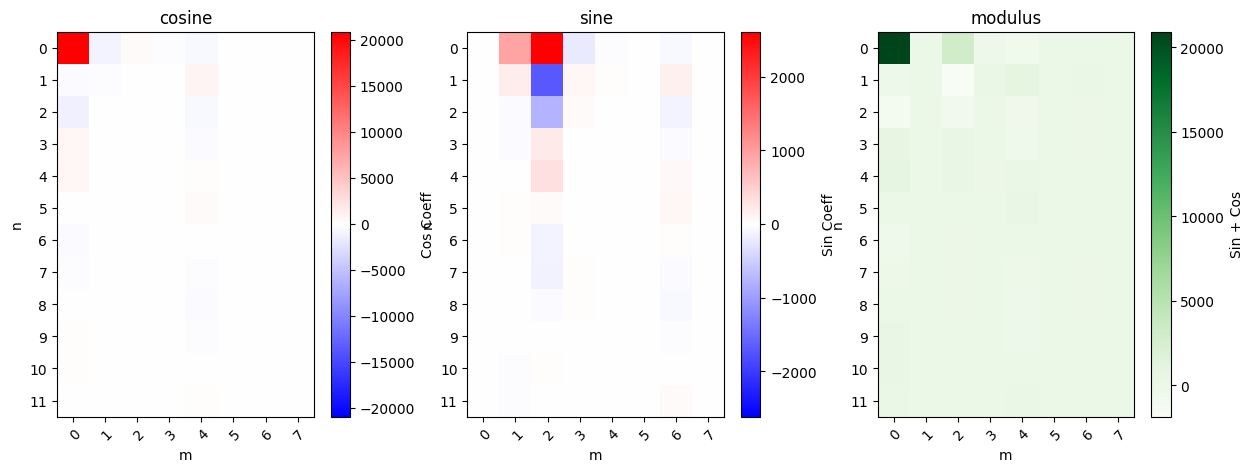

In [20]:
plot_coefficients_modulus(cos_cos, sin_cos)

returning coscoefs, sincoefs
max, min, median of reconstruction: 275.96601030904486 -0.7340285839700142 58.47851607908672
max, min, median of original image: 254.99999999999997 2.282845684076202 57.0799972655182
returning reconstruction, cosine coefficients, and sine coefficients


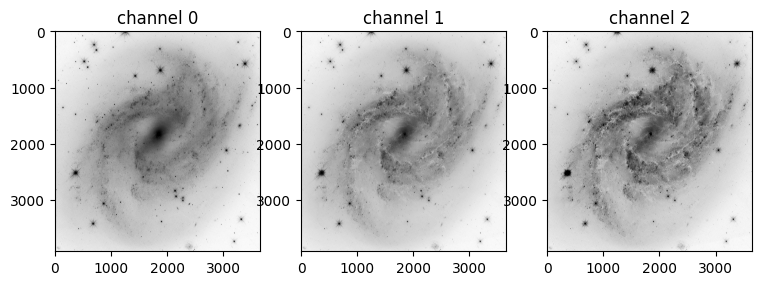

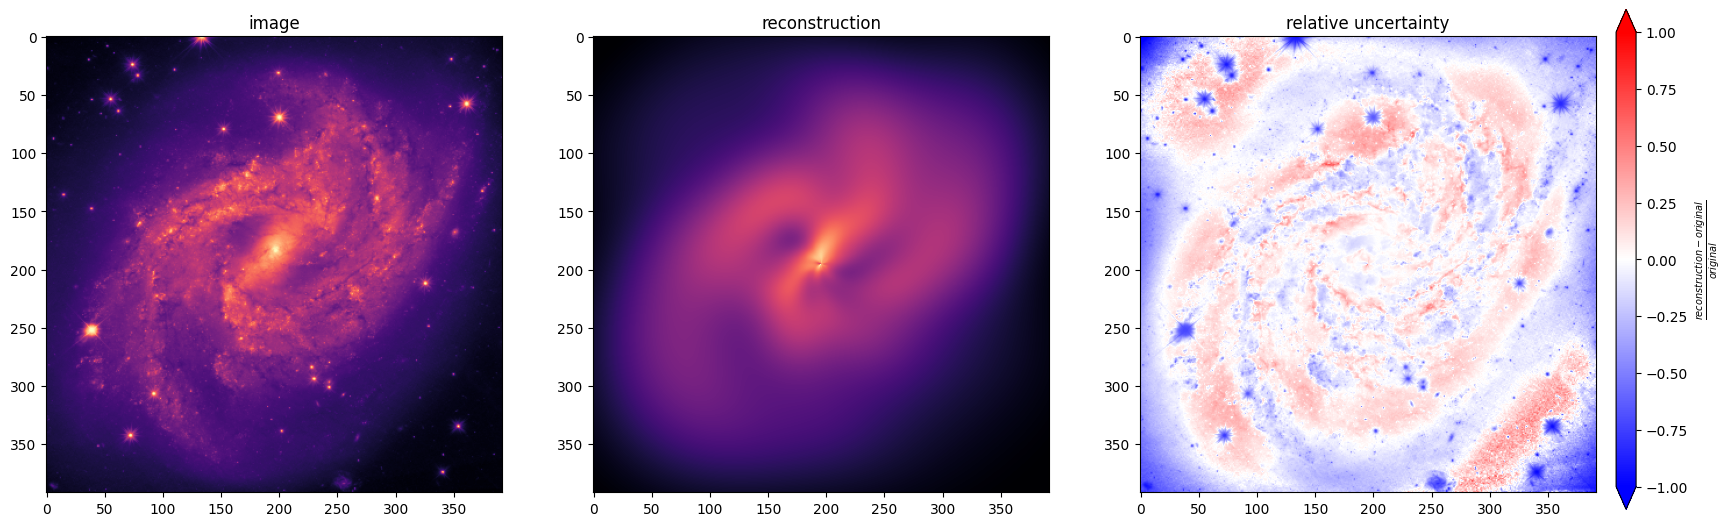

In [21]:
spiral_recon, spiral_cos_cos, spiral_sin_cos = beef_it('high_qual_barredspiral_ngc2525.tif', rescale_factor=.1, 
                                  rscale=500, recon_lims=3000)

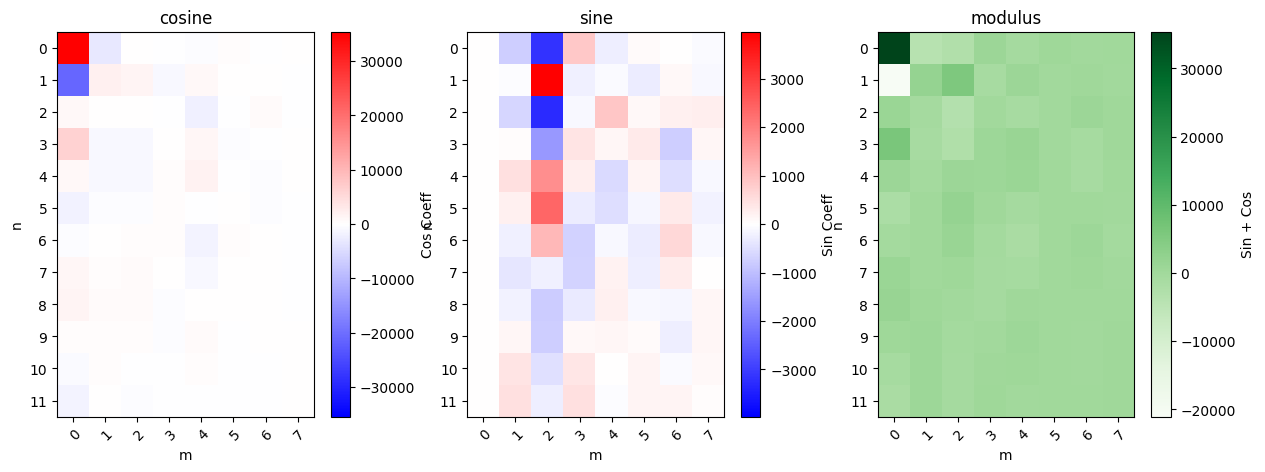

In [22]:
plot_coefficients_modulus(spiral_cos_cos, spiral_sin_cos)

In [23]:
def og_map_to_sounds(cos_cos, sin_cos):#, mmax, nmax):
    note_list = np.array(['Gb','Db','Ab','Eb','Bb','F','C','G','D','A','E','B','F#','C#','G#','D#','A#']) #pythagorean chromatic scale
    min_max_bar_c = (cos_cos.copy()).flatten()
    min_max_bar_s = (sin_cos.copy()).flatten()

    mmax = cos_cos.shape[0]
    nmax = cos_cos.shape[1]

    #what is the highest amplitude coeefficient (looking at both sin and cos)
    min_max_av_im1_c = (cos_cos.copy()).flatten()
    min_max_av_im1_s = (sin_cos.copy()).flatten()
    #getting minimum, maximums for coefficients (helpful in setting color range)
    min_b_s, max_b_s = np.min(min_max_av_im1_s), np.max(min_max_av_im1_s)
    min_b_c, max_b_c = np.min(min_max_av_im1_c), np.max(min_max_av_im1_c)
    
    vmin_av_im1_c, vmax_av_im1_c = find_vmin_vmax(min_b_c, max_b_c)
    vmin_av_im1_s, vmax_av_im1_s = find_vmin_vmax(min_b_s, max_b_s)
    
    abs_max = np.max(np.array([np.max(abs(min_max_bar_c)),np.max(abs(min_max_bar_s))]))
    
    c_bar_copy = cos_cos.copy()
    s_bar_copy = sin_cos.copy()
    note_cos = NoteContainer()
    note_sin = NoteContainer()
    note_tote = NoteContainer()
    for m in range(mmax):
        octave = m
        for n in range(nmax):
            amp_c = c_bar_copy[m,n]
            amp_s = s_bar_copy[m,n]
            if abs(amp_c) >= .025*abs_max: #if the amplitude of this coefficient is at least 2.5% the maximum, we will make it audible
                if amp_c > 0: #if the amplitude is positive, use channel one so we can use different instruments for positive and negative coeffs
                    noteys = Note(note_list[n],octave=octave,channel=1)
                    note_cos.add_notes(noteys)
                    note_tote.add_notes(noteys)
                else: #if the amplitude is negative, use channel two
                    noteys = Note(note_list[n],octave=octave,channel=2)
                    note_cos.add_notes(noteys)
                    note_tote.add_notes(noteys)
            
            if abs(amp_s) >= .025*abs_max: #repeat for sin
                if amp_s > 0:
                    noteys = Note(note_list[n],octave=octave,channel=1)
                    note_sin.add_notes(noteys)
                    note_tote.add_notes(noteys)
                else:
                    noteys = Note(note_list[n],octave=octave,channel=2)
                    note_sin.add_notes(noteys)
                    note_tote.add_notes(noteys)
    print('returning full set of notes, followed by notes from the cosine coefficients and notes from the sin coefficients')
    return note_tote #,  note_cos, note_sin





In [24]:
def mod_map_to_sounds(cos_cos, sin_cos):
    note_list = np.array(['Gb','Db','Ab','Eb','Bb','F','C','G','D','A','E','B','F#','C#','G#','D#','A#']) #pythagorean chromatic scale
    
    mmax = cos_cos.shape[0]
    nmax = cos_cos.shape[1]

    modulus = cos_cos + sin_cos
    min_modulus = np.min(((modulus).copy()).flatten())
    max_modulus = np.max(((modulus).copy()).flatten())
    
    
    abs_max = np.max(np.array([np.max(abs(max_modulus)),np.max(abs(min_modulus))]))

    vols = 100 * (abs(modulus)/abs_max)
    modulus_copy = modulus.copy()
    note_tote = NoteContainer()
    for m in range(mmax):
        octave = m
        for n in range(nmax):
            amp = modulus_copy[m,n]
            #if amp < 0:
            #    print('neg', vols[m,n])
            if abs(amp) >= .025*abs_max: #if the amplitude of this coefficient is at least 2.5% the maximum, we will make it audible
                if amp > 0: #if the amplitude is positive, use channel one so we can use different instruments for positive and negative coeffs
                    noteys = Note(note_list[n],octave=octave,channel=1)#, dynamics={'velocity':vols[m,n]})
                    note_tote.add_notes(noteys)
                else: #if the amplitude is negative, use channel two
                    noteys = Note(note_list[n],octave=octave,channel=2)#, dynamics={'velocity':vols[m,n]})
                    note_tote.add_notes(noteys)

    print('returning full set of notes')
    return note_tote, vols

In [25]:
#plt.hist((cos_cos.flatten()+sin_cos.flatten())/(np.max(cos_cos.flatten()+sin_cos.flatten())))

In [26]:
notes, vols = mod_map_to_sounds(cos_cos, sin_cos)
fluidsynth.play_NoteContainer(notes, channel=[note.channel for note in notes])#, 
#                             velocity={'volume': [note.dynamics['velocity'] for note in notes]})
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(notes))

returning full set of notes


True

In [27]:
midi_file_out.write_NoteContainer("mystery_sound_a.mid", notes, bpm=5, verbose=True)
midi_file_out.write_NoteContainer("elliptical_ngc4621_mod.mid", notes, bpm=5, verbose=True)
#barredspiral_ngc2525_mod

Written 203 bytes to mystery_sound_a.mid.
Written 203 bytes to elliptical_ngc4621_mod.mid.


True

In [29]:
! fluidsynth -F mystery_sound_a.wav /Users/caf/Developer/sonify/env/GeneralUser\ GS\ 1.471/soundfont.sf2 mystery_sound_a.mid

FluidSynth runtime version 2.3.3
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'mystery_sound_a.wav'..


In [30]:
! fluidsynth -F elliptical_ngc4621_mod.wav /Users/caf/Developer/sonify/env/GeneralUser\ GS\ 1.471/soundfont.sf2 elliptical_ngc4621_mod.mid

FluidSynth runtime version 2.3.3
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'elliptical_ngc4621_mod.wav'..


In [12]:
notes, vols = mod_map_to_sounds(cos_cos, sin_cos)
og_notes = og_map_to_sounds(cos_cos, sin_cos)
[note.channel for note in og_notes], [note.channel for note in notes]

returning full set of notes
returning full set of notes, followed by notes from the cosine coefficients and notes from the sin coefficients


([1, 1, 2, 1, 2, 2, 1, 2, 1, 2], [1, 1, 2, 1, 2, 1, 2, 1, 2])

In [13]:
og_notes = og_map_to_sounds(cos_cos, sin_cos)
fluidsynth.play_NoteContainer(og_notes, channel=[note.channel for note in og_notes], 
                             velocity={'volume': [note.dynamics['velocity'] for note in og_notes]})
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(og_notes))

returning full set of notes, followed by notes from the cosine coefficients and notes from the sin coefficients


True

In [31]:
spiral_notes, spiral_vols = mod_map_to_sounds(spiral_cos_cos, spiral_sin_cos)
fluidsynth.play_NoteContainer(spiral_notes, channel=[note.channel for note in spiral_notes])#, 
#                             velocity={'volume': [note.dynamics['velocity'] for note in notes]})
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(spiral_notes))

returning full set of notes


True

In [15]:
spiral_notes_og = og_map_to_sounds(spiral_cos_cos, spiral_sin_cos)
fluidsynth.play_NoteContainer(spiral_notes_og, channel=[note.channel for note in spiral_notes_og])#, 
#                             velocity={'volume': [note.dynamics['velocity'] for note in notes]})
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(spiral_notes_og))

returning full set of notes, followed by notes from the cosine coefficients and notes from the sin coefficients


True

In [40]:
spiral_notes, spiral_notes_og

(['Db-0', 'D-0', 'Eb-0', 'F-0', 'Gb-0', 'G-0', 'Ab-0', 'Bb-0', 'B-0', 'Db-1', 'Eb-1', 'Gb-1', 'Bb-1', 'C-2', 'Db-2', 'D-2', 'Eb-2', 'F-2', 'Gb-2', 'Ab-2', 'Bb-2', 'Db-3', 'C-4', 'Db-4', 'Eb-4', 'G-4', 'Ab-4', 'Bb-4'],
 ['Db-0', 'D-0', 'Eb-0', 'F-0', 'Gb-0', 'G-0', 'Ab-0', 'Bb-0', 'B-0', 'Db-1', 'Eb-1', 'Gb-1', 'C-2', 'Db-2', 'Eb-2', 'F-2', 'Gb-2', 'Ab-2', 'Bb-2', 'C-4', 'Db-4', 'Eb-4', 'G-4', 'Ab-4', 'Bb-4'])

In [38]:
midi_file_out.write_NoteContainer("mystery_sound_b.mid", spiral_notes, bpm=5, verbose=True)
midi_file_out.write_NoteContainer("barredspiral_ngc2525_mod.mid", spiral_notes, bpm=5, verbose=True)

Written 499 bytes to mystery_sound_b.mid.
Written 499 bytes to barredspiral_ngc2525_mod.mid.


True

In [39]:
! fluidsynth -F mystery_sound_b.wav /Users/caf/Developer/sonify/env/GeneralUser\ GS\ 1.471/soundfont.sf2 mystery_sound_b.mid

FluidSynth runtime version 2.3.3
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'mystery_sound_b.wav'..


In [40]:
! fluidsynth -F barredspiral_ngc2525_mod.wav /Users/caf/Developer/sonify/env/GeneralUser\ GS\ 1.471/soundfont.sf2 barredspiral_ngc2525_mod.mid

FluidSynth runtime version 2.3.3
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'barredspiral_ngc2525_mod.wav'..


In [18]:
spiral_notes, spiral_notes_og

(['Db-0', 'D-0', 'Eb-0', 'F-0', 'Gb-0', 'G-0', 'Ab-0', 'Bb-0', 'B-0', 'Db-1', 'Eb-1', 'Gb-1', 'Bb-1', 'C-2', 'Db-2', 'D-2', 'Eb-2', 'F-2', 'Gb-2', 'Ab-2', 'Bb-2', 'Db-3', 'C-4', 'Db-4', 'Eb-4', 'G-4', 'Ab-4', 'Bb-4'],
 ['Db-0', 'D-0', 'Eb-0', 'F-0', 'Gb-0', 'G-0', 'Ab-0', 'Bb-0', 'B-0', 'Db-1', 'Eb-1', 'Gb-1', 'C-2', 'Db-2', 'Eb-2', 'F-2', 'Gb-2', 'Ab-2', 'Bb-2', 'C-4', 'Db-4', 'Eb-4', 'G-4', 'Ab-4', 'Bb-4'])

returning coscoefs, sincoefs
max, min, median of reconstruction: 276.9928653619525 0.024377543422857098 61.68450727836127
max, min, median of original image: 254.00000000000009 7.4630411831955605 60.34310027610238
returning reconstruction, cosine coefficients, and sine coefficients


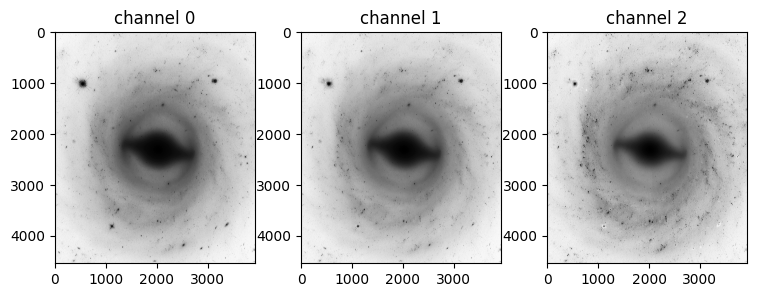

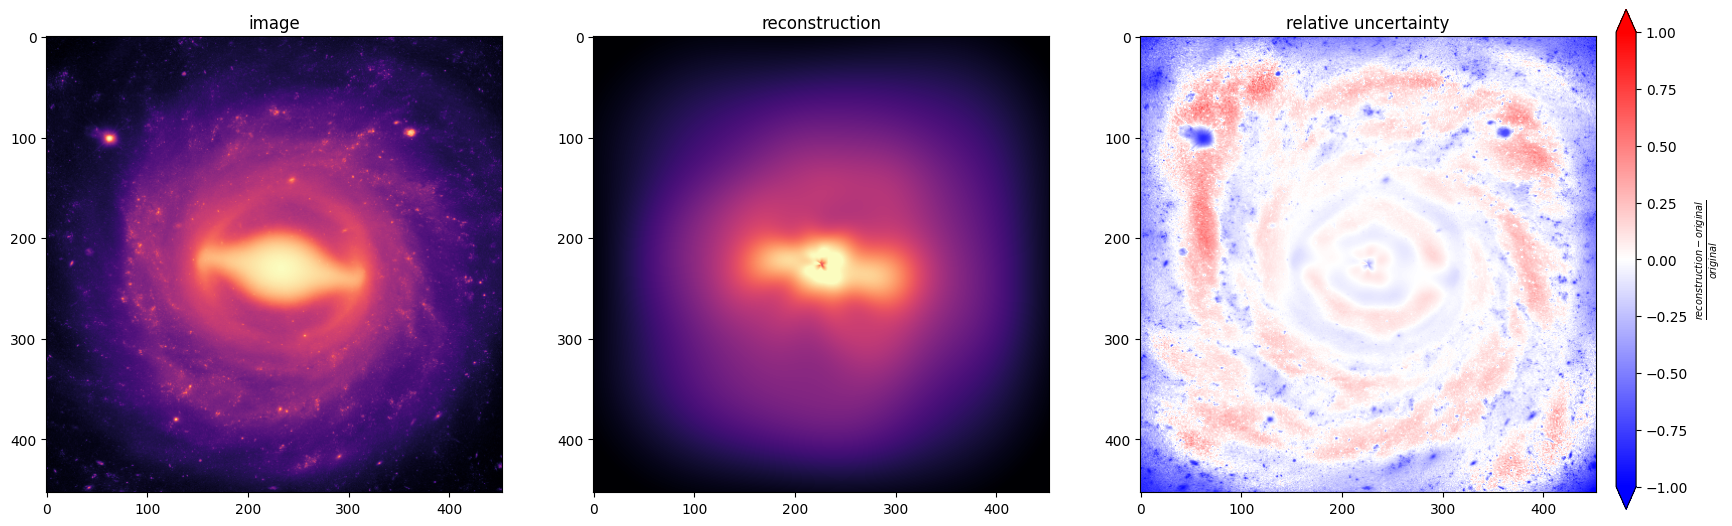

In [41]:
recon_bar, cos_cos_bar, sin_cos_bar = beef_it('high_qual_barring_ngc1015.tif', rescale_factor=.1, 
                                  rscale=500, recon_lims=3000)

In [42]:
notes, vols = mod_map_to_sounds(cos_cos_bar, sin_cos_bar)
fluidsynth.play_NoteContainer(notes, channel=[note.channel for note in notes])#, 
#                             velocity={'volume': [note.dynamics['velocity'] for note in notes]})
time.sleep(2)
fluidsynth.stop_NoteContainer(NoteContainer(notes))

returning full set of notes


True

In [43]:
midi_file_out.write_NoteContainer("barring_ngc1015_mod.mid", spiral_notes, bpm=5, verbose=True)

Written 499 bytes to barring_ngc1015_mod.mid.


True

In [44]:
! fluidsynth -F barring_ngc1015_mod.wav /Users/caf/Developer/sonify/env/GeneralUser\ GS\ 1.471/soundfont.sf2 barring_ngc1015_mod.mid

FluidSynth runtime version 2.3.3
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'barring_ngc1015_mod.wav'..


# playing sounds - 
## sine/cosine mapping doesnt differ too much from the modulus mapping

starting fluidsynth in the terminal
load /Users/caf/Developer/sonify/env/GeneralUser\ GS\ 1.471/soundfont.sf2
prog 2 49 
prog 1 1 

to set channel 2 to inst 49 and channel 1 to inst 1 (i.e. violin, piano)

In [ ]:
# maybe want to play around with /not/ having m = 0, n = 0 be a sound?